<a href="https://colab.research.google.com/github/SleepingSamael/Image-Processing/blob/main/Lif2Tif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Mount google driver 
For using the files in Google Drive, we need to mount Google Drive first. Just click the triangle button and ignore the outputs.

If it asks for authentication in a pop-up, allow it.

In [ ]:
#@markdown Mount google driver
from google.colab import drive
drive.mount('/content/drive')

## 2. Initialization settings

The working folder contains the script, environment, and parameter files. 
You can regard this folder as the whole program. 
This setting is only to specify the path of the main program. 
Please move the whole "Pipeline" folder if you want to run this script in another folder or account.

**The input and output files are best saved in other folders.** 
Their path settings are in after codes.

### An easy way to get the path:

Click the file icon on the left.

Get your file/folder and, right-clicking it, choose "Copy path." 

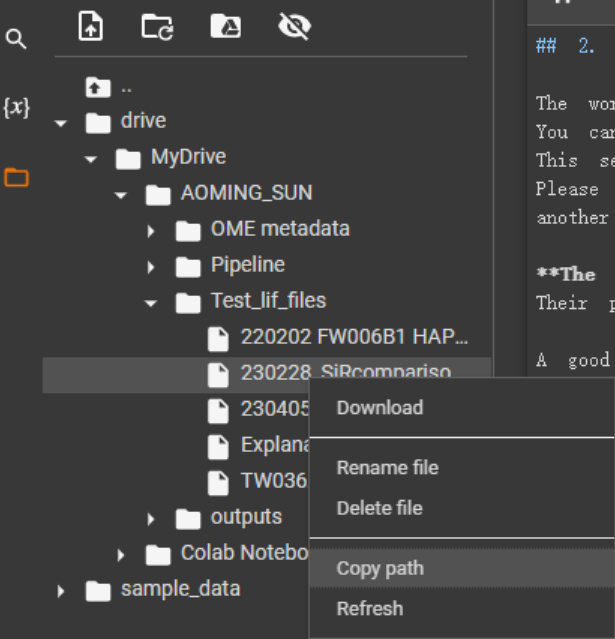


In [ ]:
#@markdown ### Set the working folder
import os
import sys
path = "/content/drive/MyDrive/AOMING_SUN/Pipeline"#@param {type:"string"}

os.chdir(path)
os.listdir(path)

sys.path.append(os.path.abspath(path))
sys.path.append("/content/drive/MyDrive/AOMING_SUN/Pipeline/Lif2Tifenv/lib/python3.10/site-packages")

#@markdown ### Set path of target images
#@markdown Specify the lif file you want to process, and notice that an absolute path is used.
_input = "/content/drive/MyDrive/AOMING_SUN/Test_lif_files/220202 FW006B1 HAP1 sGFP2-CTNNB1 ON Imaging Low Wnt3a range.lif" #@param {type:"string"}

In [ ]:

# nb_path = '/content/drive/MyDrive/AOMING_SUN/Pipeline/L2Tenv'


# python 'python-javabridge-4.0.3/setup.py' install
# # !pip install --target=$nb_path pandas
# !python 'python-javabridge-4.0.3/setup.py' install --target  nb_path


In [ ]:
#@markdown Click Play to Install requirement packages. Requirement file is the working folder.
%%capture
!sudo apt-get install -y openjdk-11-jdk
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
!pip install python-javabridge -i https://pypi.python.org/simple/
!pip3 install -r requirements1.txt


In [ ]:
#@markdown Import packages
# Built-in imports
from pathlib import Path
import LUTs
import utils
import itertools
import struct
import sys
import os
import re
import csv

# Third-party imports


import numpy as np
import pandas as pd
import tifffile
import tqdm
import javabridge
import bioformats
from javabridge import jutil

_javabridge_opened = False

## 3. The functions (keep this part folded if you don't want to modify the codes )

In [ ]:
#@markdown Controller for solving vm probles in javabridge

def javabridge_controller(operation):
    global _javabridge_opened
    if operation == 'open':
        if not _javabridge_opened:
            javabridge.start_vm(class_path=bioformats.JARS)
            _javabridge_state = True
        else:
            pass
    elif operation == 'close':
        if not _javabridge_opened:
            pass
        else:
            javabridge.kill_vm()
    else:
        raise ValueError


In [ ]:
#@markdown Function for saving metadata as xml file
def save_ome_xml_matadata(file_name):
    javabridge_controller('open')
    try:
            # Get omexml metadata stored in the lif file
            o = bioformats.get_omexml_metadata(_input)

            from xml.dom.minidom import parseString
            os.makedirs('OME-XML metadata', exist_ok=True)
            f = open(f'OME-XML metadata/{file_name}.xml', 'w', encoding='utf-8')
            f.write(o)
            f.close()
            print("METADATA file SAVED")
    finally:
        javabridge_controller('close')
        

In [ ]:
#@markdown Function for getting metadata
def get_metadata():
    javabridge_controller('open')
    try:
        omemeta = bioformats.omexml.OMEXML(bioformats.get_omexml_metadata(_input))
        n_images = omemeta.get_image_count()

        series = '0-%d' % (n_images - 1)
        series = utils.parse_series(series)

        output_info = []
        for srs in series:
            meta = omemeta.image(srs)
            name = meta.get_Name()
            channel = meta.Pixels.channel
            n_t = meta.Pixels.SizeT
            n_z = meta.Pixels.SizeZ
            n_c = meta.Pixels.SizeC
            n_y = meta.Pixels.SizeY
            n_x = meta.Pixels.SizeX
            physical_size_x = meta.Pixels.get_PhysicalSizeX()
            physical_size_x_unit = meta.Pixels.get_PhysicalSizeXUnit()
            physical_size_y = meta.Pixels.get_PhysicalSizeY()
            physical_size_y_unit = meta.Pixels.get_PhysicalSizeYUnit()
            physical_size_z = meta.Pixels.get_PhysicalSizeZ()
            physical_size_z_unit = meta.Pixels.get_PhysicalSizeZUnit()
            dimension_order = meta.Pixels.get_DimensionOrder()
            pxtype = meta.Pixels.get_PixelType()
            bit_depth = utils.get_int_from_str(pxtype)

            
            output = {"Series": srs,
                          "Image name": name,
                          "Dimension": "XYCTZ" + ', ' + 'x'.join(map(str, [n_x, n_y, n_c, n_t, n_z])),
                          "Physical size X": physical_size_x,
                          "Physical size Y": physical_size_y,
                          "Physical size Z": physical_size_z,
                          "Physical size unit": physical_size_x_unit,
                          "Pixel type": pxtype,
                          "File size(without compression)(mb)": ((n_x * n_y * n_c * n_z * n_t) * bit_depth/8)/(1024*1024) }

            output_info.append(output)
        return pd.DataFrame(output_info)
    finally:
        javabridge_controller('close')



In [ ]:
#@markdown Main funcion
def main(meta_csv,selected_properties):
    javabridge_controller('open')

    try:
        omemeta = bioformats.omexml.OMEXML(bioformats.get_omexml_metadata(_input))
        n_images = omemeta.get_image_count()
        series = _series
        if series == 'all':
            series = '0-%d' % (n_images - 1)
        else:
            series = series
        series = utils.parse_series(series)

        for srs in series:
            meta = omemeta.image(srs)
            name = meta.get_Name()
            n_t = meta.Pixels.SizeT
            n_z = meta.Pixels.SizeZ
            n_c = meta.Pixels.SizeC
            n_y = meta.Pixels.SizeY
            n_x = meta.Pixels.SizeX
            physical_size_x = meta.Pixels.get_PhysicalSizeX()
            physical_size_y = meta.Pixels.get_PhysicalSizeY()
            physical_size_z = meta.Pixels.get_PhysicalSizeZ()


            # Get the selected information from metadata csv file
            filtered_csv = meta_csv[meta_csv["Series"] == srs][selected_properties].to_dict(orient='records')[0]

            if any(x in [physical_size_x,physical_size_y] for x in 
                   (None, 'null',float('nan'),float('NaN'))):
              continue


            rdr = bioformats.ImageReader(_input)

            # Through following command one may get other metadata such as microscope settings
            # jdict(rdr.rdr.getSeriesMetadata())

            if _c is None or len(_c) == 0:
                ch = range(n_c)
            else:
                ch = _c
            if _z_min is None:
                z0 = 0
            else:
                z0 = _z_min
            if _z_max is None:
                z1 = n_z
            else:
                z1 = min(_z_max, n_z)
            if _t_min is None:
                t0 = 0
            else:
                t0 = _t_min
            if _t_max is None:
                t1 = n_t
            else:
                t1 = min(n_t, _t_max)

            if _stack: img_stack = None
            iterator = list(itertools.product(ch, range(z0, z1), range(t0, t1)))
            for i, (c, z, t) in tqdm.tqdm(
                    enumerate(iterator), total=len(iterator)):
                img = rdr.read(c=c, z=z, t=t, series=srs)

                if _dtype is not None:
                    try:
                        vmax = np.iinfo(_dtype).max
                    except ValueError:
                        vmax = 1.0

                    if img.dtype.name.startswith("float"):
                        img = img * vmax

                    img = img.astype(_dtype)

                dtype = _dtype or img.dtype

                # imagej hyperstack must be in TZCYXS order
                if _stack:
                    if i == 0:
                        img_stack = np.zeros([t1 - t0, z1 - z0, len(ch), *img.shape], dtype=dtype)
                    img_stack[t, z, c, ...] = img

                else:
                    name_formate = re.sub(r'[\s\\/]', "_", name)
                    output_pattern = prefix
                    for k,v in filtered_csv.items():
                      reg_str_v =str(v).replace("\\", "_").replace("/", "_").replace(".", "_")
                      if output_pattern:
                        output_pattern = output_pattern + '_'+ reg_str_v
                      else:
                        output_pattern = reg_str_v
                    output_pattern = output_pattern + f"_t{t:03d}_c{c:02d}.tiff"
                    

                    path = Path(_output_path) / output_pattern
                    print(path)
                    if not os.path.exists(os.path.dirname(path)):
                        os.mkdir(os.path.dirname(path))
                    tifffile.imsave(path, img, compressionargs=_compression)

            if _stack:
                name_formate = re.sub(r'[\s\\/]', "_", name)
                output_pattern = prefix
                for k,v in filtered_csv.items():
                    reg_str_v =str(v).replace("\\", "_").replace("/", "_").replace(".", "_")
                    if output_pattern:
                      output_pattern = output_pattern + '_'+ reg_str_v
                    else:
                      output_pattern = reg_str_v
                output_pattern = output_pattern + ".tiff"
                path = Path(_output_path) / output_pattern
                print(path)
                if not os.path.exists(os.path.dirname(path)):
                    os.mkdir(os.path.dirname(path))

                ijmeta = {'spacing': physical_size_z, 'unit': 'micron', 'axes': 'TZCYX', 'mode': 'composite'}
                ijtags = utils.imagej_metadata_tags({'LUTs': LUTs.LUT_CYCLE[:len(ch)]}, '>')

                tifffile.imwrite(path, img_stack, compressionargs=_compression, byteorder='>',
                                 imagej=True, resolution=(1. / physical_size_y, 1. / physical_size_x),
                                 metadata=ijmeta, extratags=ijtags)
    finally:
        javabridge_controller('close')



## Set path of the metadata file.
If a LIF file was opened for the first time, please run step 4 and save its metadata as a csv file.

In [ ]:
#@markdown ### The folder which contains all the metadata files:
metadata_dir_path = '../OME metadata/' #@param {type:"string"}
lif_file_name = _input.split('/')[-1]
metadata_name = lif_file_name+'.csv'
#@markdown The program will automatically traverse this folder to find the CSV file with the same name as the input lif file.
#@markdown Or if you want to specify the CSV file, please input its path below:

#@markdown ### File path of specify metadata file(end with .csv).
metadata_path = '' #@param {type:"string"}
if not metadata_path:
  metadata_path = metadata_dir_path + metadata_name

if not os.path.exists(metadata_path):
  metadata_path = None

print(metadata_path)

#@markdown If the specified file path doesn't exist or the same-name-file can't be found in the folder, the metadata-save program will enforce.



## 4. Show the metadata of lif file.
This step is compulsory when opening a LIF file for the first time.

In [ ]:
#@markdown ### Show metadata:
#@markdown #### Data can be filtered, sorted, and explored dynamically by interactive displays.

#@markdown Check to choose whether to run.
#@markdown If the input metadata is not specified above, here is set to must run.
metadata_show = True #@param {type:"boolean"}
if not metadata_path:
  metadata_show = True

if metadata_show:
  from google.colab import data_table
  data_table.enable_dataframe_formatter()
  df_output = get_metadata()
  display(df_output)

In [ ]:
#@markdown #### Whether to save the table as a csv file.
#@markdown If the input metadata is not specified above, here is set to must save.
save_metadata = True #@param {type:"boolean"}
if not metadata_path:
  save_metadata = True
#@markdown #### Path of csv saved (Both absolute and relative paths are fine)
csv_path = '../OME metadata/' #@param {type:"string"}
#@markdown #### Automatically use the lif file name as the metadata file name
info_file_name = lif_file_name
if save_metadata:
  os.makedirs(csv_path,exist_ok=True)
  if os.path.exists(csv_path+info_file_name+".csv"):
    info_file_name=info_file_name+'(1)'
    df_output.to_csv(csv_path+info_file_name+".csv",index=False)
  else:
    df_output.to_csv(csv_path+info_file_name+".csv",index=False)
  metadata_path = csv_path +lif_file_name+".csv"
  print(f"{info_file_name}.csv FILE SAVED")

In [ ]:
#@markdown #### Whether to save the whole metadata as xml
if_save_xml = False #@param {type:"boolean"}
#@markdown #### File name of xml
xml_file_name = "metadata" #@param {type:"string"}

if if_save_xml:
    save_ome_xml_matadata(xml_file_name)

## 5. Set parameters and convert lif file to tiff files 

In [ ]:
#@markdown ### Get attributes  from metadata files:
meta_csv = utils.get_csv_file(metadata_path)
display(meta_csv.head())
properties=list(meta_csv.columns) 
#print('properties:',properties)

In [ ]:
#@markdown ### Select Attributes used in naming tiff files:
#@markdown ####The selected attributes will be parts of names of output images.
#@markdown The names of images in *Planes* mode will be in the format: `prefix_Attribute1_Attribute2_Attribute3_...timepoint(t001)_channel(c01).tiff`,
#@markdown timepoint and channel are mandatory attributes.
#@markdown $$$$The names of imaged in *Stacks* mode will be in the format: `prefix_Attribute1_Attribute2_Attribute3_..._AttributeN.tiff`
from time import process_time_ns
import requests
import random
import ipywidgets as wid

selected_properties = []

def multi_checkbox_widget(options_dict):
    """ Widget with a search field and lots of checkboxes """
    search_widget = wid.Text()
    output_widget = wid.Output()
    options = [x for x in options_dict.values()]
    options_layout = wid.Layout(
        overflow='auto',
        border='1px solid black',
        width='500px',
        height='500px',
        flex_flow='column',
        display='flex'
    )
    
    #selected_widget = wid.Box(children=[options[0]])
    options_widget = wid.VBox(options, layout=options_layout)
    #left_widget = wid.VBox(search_widget, selected_widget)
    multi_select = wid.VBox([search_widget, options_widget])

    @output_widget.capture()
    def on_checkbox_change(change):
        
        selected_recipe = change["owner"].description
        #print(options_widget.children)
        #selected_item = wid.Button(description = change["new"])
        #selected_widget.children = [] #selected_widget.children + [selected_item]
        options_widget.children = sorted([x for x in options_widget.children], key = lambda x: x.value, reverse = True)
        
    for checkbox in options:
        checkbox.observe(on_checkbox_change, names="value")

    # Wire the search field to the checkboxes
    @output_widget.capture()
    def on_text_change(change):
        search_input = change['new']
        if search_input == '':
            # Reset search field
            new_options = sorted(options, key = lambda x: x.value, reverse = True)
        else:
            # Filter by search field using difflib.
            #close_matches = difflib.get_close_matches(search_input, list(options_dict.keys()), cutoff=0.0)
            close_matches = [x for x in list(options_dict.keys()) if str.lower(search_input.strip('')) in str.lower(x)]
            new_options = sorted(
                [x for x in options if x.description in close_matches], 
                key = lambda x: x.value, reverse = True
            ) #[options_dict[x] for x in close_matches]
        options_widget.children = new_options

    search_widget.observe(on_text_change, names='value')
    display(output_widget)
    return multi_select

options_dict = {
    x: wid.Checkbox(
        description=x, 
        value=False,
        style={"description_width":"0px"}
    ) for x in properties
}

def f(**args):
    results = [key for key, value in args.items() if value]
    global selected_properties
    selected_properties = results
    print("Selected properties:",results)

ui = multi_checkbox_widget(options_dict)
out = wid.interactive_output(f, options_dict)
display(wid.HBox([ui, out]))

In [ ]:
#@markdown ### Get parameter from parameter files:
print(selected_properties)
paras = utils.get_paras('Parameter files/Lif2Tif.csv')[0]
description = utils.get_paras('Parameter files/Lif2Tif.csv')[1]


In [ ]:
# #Third-party Jupyter widgets
# #Support for third party widgets (widgets outside of the ipywidgets package) needs to be enabled separately. Support for these widgets will be loaded from a CDN external from Colab.
# from google.colab import output
# output.enable_custom_widget_manager()


# #@markdown ### Show parameter:
# import ipywidgets as widgets
# #from IPython.display import display
# from ipywidgets import HBox, Label
# def on_value_change(change):
#     new_value = change['new']
#     print(f"Value changed to: {new_value}")
# for k,v in paras.items():
#   if isinstance(v,bool):
#     w = widgets.Checkbox(value=v,description=k,disabled=False)
#   elif isinstance(v,int):
#     w = widgets.BoundedIntText(value=v,min=1,max=9,step=1,description=k,disabled=False)
#   else:
#     w = widgets.Text(description=k,value=v,disabled=False,layout=widgets.Layout(width='30%',height='40px'))
    
#   w.observe(on_value_change,names='value')  
#   display(HBox([w,Label(description.get(k))]))

In [ ]:
# _output_path = paras.get('output_path')
# _output_pattern = paras.get('output_pattern')
# _z_min = paras.get('z_min') 
# _z_max = paras.get('z_max') 
# _c = paras.get('channels') 
# _t_min = paras.get('t_min') 
# _t_max = paras.get('t_max') 
# _series = paras.get('series') 
# _compression = paras.get('compression')
# _stack = paras.get('stack') 
# _dtype = paras.get('dtype')
# _stack_output_pattern = paras.get('output')

### Set output configuration:
* output_option: 
> Select output type.
    - Stacks - Output each series as a single collated tiff: [imagej hyperstack](https://imagej.nih.gov/ij/docs/guide/146-8.html).
    - Planes - Split each plane(one 2-dimensional image plane) as a separate image and output it as a tiff.

*  \_prefix: 
> The prefix of image name, if you select ['Series', 'Image name', 'treatment'] as the properties, then the prefix of the image name will be included in the full image name and it will be in the format `prefix_Series_Image name_treatment_timepoint_channel.tiff` in *Planes* mode and `prefix_Series_Image name_treatment.tiff` in *Stacks* mode . Keep it empry if prefix was not needed.



In [ ]:
_output_path = "../outputs"

output_option = "Stacks" #@param ["Stacks", "Planes"]
if output_option == "Stacks":
  _stack = True
else:
  _stack = False

prefix = "FW006B1"#@param {type:"string"}
#_stack_output_pattern = "../stack_outputs/output{srs:03d}.tiff" #@param{type:"string"}

**Set parameter:** 

*   series the zero-based series # to be read out of the .lif file. A quick trick here is to open the .lif in Fiji and subtract 1 from the series you want.

*   z-min read z frames starting at this z (default 0).

*   z-max read z frames up until this z (default all z).

*   c read this channel index (starting at zero). This may be specified multiple times. Default is to read all channels.

*   t-min read time frames starting at this t (default 0).

*   t-max read time frames up until this t.

*   compression compression level (0-9) for tiffs, defaults to 3.


*   dtype is the pixel data type for the output. To convert a floating- point .lif file to 16 bit TIFF, use "--dtype uint16". The data will be scaled from floating point 0-1 to the integer data type.















In [ ]:


#@markdown #### Minimum z frame to process. Default(no input) is all.
_z_min = None #@param {type:"raw"}

#@markdown #### Non-inclusive maximum z frame to process.
_z_max = None #@param {type:"raw"}

#@markdown #### Channels to process. Can be specified multiple
_c = None #@param {type:"raw"}

#@markdown #### Minimum time frame to process. Default is all.
_t_min = None #@param {type:"raw"}

#@markdown #### Maximum time frame to process. Default is all.
_t_max = None #@param {type:"raw"}


#@markdown #### The series of images to be processed, starting at zero. <br />Hint - open it up in Fiji to see, then subtract 1. 'all' for extracting all series
_series = "all" #@param{type:"raw"}

#@markdown #### Compression to use when writing tiff files.
_compression = 3 #@param{typr:"number"}


#@markdown #### The numpy pixel datatype.
_dtype = None #@param{type:"raw"}



In [ ]:
#@markdown ### Convert 
#@markdown Check to choose whether to run.
lif2tif_run = True #@param {type:"boolean"}
print(selected_properties)

if lif2tif_run:
  
  main(meta_csv,selected_properties)